<a href="https://colab.research.google.com/github/charleswongzx/flower17-svm/blob/master/Flowers17_ML_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 50.039 Theory and Practice of Deep Learning
## Week 1: Discriminative ML
---
Dataset features and images uploaded to Google Drive.

### Mounting Google Drive for colab local access

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Important Imports

In [0]:
import os
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import classification_report

import warnings

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

### Importing training features, applying labels.
I originally tried importing images into memory, but their relatively large filesize made this impractical. Importing the features provided was a far more sensible choice.

In [0]:
train_img_folder = 'gdrive/My Drive/Deep Learning/flowers17/feats/'
IMGS_PER_CLASS = 80

# Creating an array of features
X = []
for filename in sorted(glob(train_img_folder+'*.npy')):
  im = np.load(filename)
  X.append(im)
X = np.array(X)

# Generating labels in intervals of 80
y = [label for label in range(int(1360/IMGS_PER_CLASS)) for y in range(80)]

print("Working with {0} images".format(len(X)))
NUM_CLASSES = int(len(X)/IMGS_PER_CLASS)

Working with 1360 images


### Train/Test/Valid Data Split
Here we perform two splits to produce 3 separate sets. `stratify` is set to True to ensure class distribution is consistent across sets.

As a a sanity check, we look at the sizes of each resultant split and a representation of even class distribution plotted as a histogram.

**PER CLASS**
Train: 40
Valid: 20
Test: 20

40.0
20.0
20.0


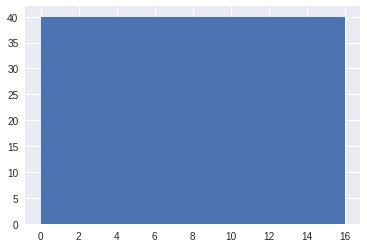

In [0]:
indices = np.arange(len(X))

X_train, X_test, y_train, y_test, idx1, id_test = train_test_split(X, y, indices, test_size=20*NUM_CLASSES, random_state=1, stratify=y)

X_train, X_val, y_train, y_val, id_train, id_val = train_test_split(X_train, y_train, idx1, test_size=20*NUM_CLASSES, random_state=1, stratify=y_train)

print(len(X_train)/NUM_CLASSES)
print(len(X_val)/NUM_CLASSES)
print(len(X_test)/NUM_CLASSES)

plt.hist(y_train, bins=NUM_CLASSES)  # proof of equal class distribution
plt.show()

### Why Classwise?
Class-wise, or stratified random sampling, ensures proportional distributions of sub-populations (in this case, individual classes) in resultant sample sets. In the context of flower17, we ensure our SVM is equally exposed to all varieties of flower during training and validation. In the event of a class imbalance, our model may be inclined to classify towards a more represented class in the training set. In the extreme case where an entire class is absent from the training set, the model is very unlikely to generalise and correctly predict a never-before-seen flower.

### Setting Up & Running Binary SVMs
Finding the best C for this task. Here, we test a range of different regularisation constants with a OneVsRestClassifier with a LinearSVC estimator.

Below is a simple line graph showing the effect of different C values on validation scores.

In [0]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

reg_constants = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.1**0.5, 1, 10**0.5, 10, 100, 1000, 10000]
scores = []
for reg in reg_constants:
  
  clf = OneVsRestClassifier(estimator=svm.LinearSVC(C=reg))
  clf.fit(X_train, y_train)
  
  score = clf.score(X_val, y_val)
  scores.append(score)

  print('C: {}'.format(reg))
  print('Score: {}'.format(score))
  print('=============')


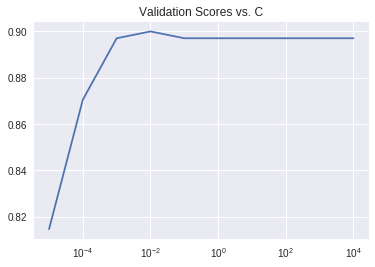

In [0]:
plt.plot(reg_constants, scores)
plt.xscale('log')
plt.title('Validation Scores vs. C')
plt.show()

Intuitively, a higher C parameter results in the SVM choosing a smaller-margin hyperplane (tighter fit) while a lower C parameter results in the opposite (looser fit). C = 0.01 appears to yield the best result. If C is too low, the SVM could be over-fitting and failing to generalise to new validation data. Scores above appear to dip slightly, perhaps due to a slight underfit, and plateau thereafter.  

### Final Training and Testing with Best C


In [0]:
X_final = np.concatenate((X_train, X_val), axis=0)
y_final = np.concatenate((y_train, y_val), axis=0)
id_final = np.concatenate((id_train, id_val), axis=0)

clf = OneVsRestClassifier(estimator=svm.LinearSVC(C=0.01))
clf.fit(X_final, y_final)

OneVsRestClassifier(estimator=LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=None)

In [0]:
y_pred = clf.predict(X_test)

In [0]:
print('Final Score: {}'.format(clf.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

Final Score: 0.9323529411764706
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        20
           1       0.87      1.00      0.93        20
           2       1.00      0.85      0.92        20
           3       0.91      1.00      0.95        20
           4       0.95      0.95      0.95        20
           5       0.95      0.90      0.92        20
           6       1.00      1.00      1.00        20
           7       0.81      0.85      0.83        20
           8       1.00      0.95      0.97        20
           9       1.00      1.00      1.00        20
          10       0.95      0.95      0.95        20
          11       0.95      0.90      0.92        20
          12       0.95      0.95      0.95        20
          13       0.90      0.95      0.93        20
          14       0.95      0.95      0.95        20
          15       0.90      0.90      0.90        20
          16       1.00      0.90      0.95      

### Reviewing Mistakes

In [0]:
image_folder = 'gdrive/My Drive/Deep Learning/flowers17/jpg/'
images = sorted(glob(image_folder+'*.jpg'))

wrong_images = []

for predicted, actual, i in zip(y_pred, y_test, id_test):
  if predicted != actual:
    print(images[i], 'has been classified as ', predicted, 'and should be ', actual)
    wrong_img = {'filename': images[i],
                 'predicted': predicted,
                 'actual': actual}
    wrong_images.append(wrong_img)

In [0]:
wrong_images = sorted(wrong_images, key = lambda i: i['actual'])

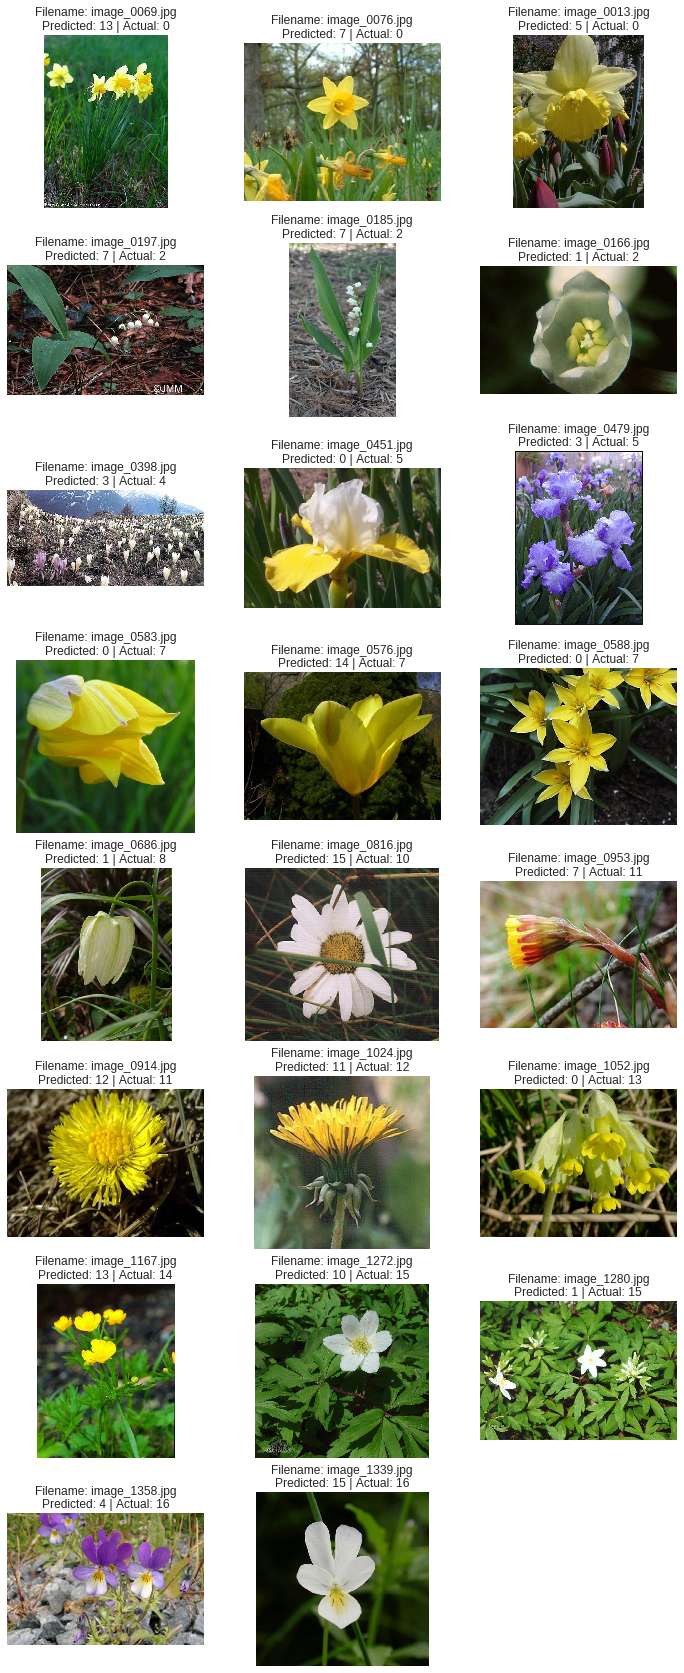

In [0]:
fig = plt.figure(figsize=(12,30))
columns = 3
rows = round(len(wrong_images)/columns)

for i in range(1, len(wrong_images)+1):
  img = wrong_images[i-1]
  a = fig.add_subplot(rows, columns, i)
  np_img = plt.imread(img['filename'])
  
  a.set_title('Filename: {}\nPredicted: {} | Actual: {}'.format(img['filename'].replace(image_folder, ''), img['predicted'], img['actual']))
  a.grid(False)
  a.set_xticks([])
  a.set_yticks([])
  
  plt.imshow(np_img)
  
plt.show()

#### Observations
*   Most commonly mis-classfied are: 0, 2 and 7.
*   0 is a yellow 5-petal flower with a central inset bell. 2 of the images (0069, 0013) appear pale, almost white, which the classifier may not have been able to generalise to.
*   0076 appears very similar to other images in the mis-classfied 7 set.
*   Classifier confuses 2 for 7 as they both feature long, thin green leaves with white flowers.
*  The 3 mis-classified 7s are all in different stages of bloom. The classifier may not have been able to generalise to flowers at different stages of development.
